In [2]:
import pandas as pd

# List the CSV file path and year corresponding to each year
file_year_map = {
    2016: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d16_v4.csv',
    2017: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d17_v4.csv',
    2018: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d18_v4.csv',
    2019: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d19_v4.csv',
    2020: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d20_v4.csv',
    2021: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d21_v4.csv',
    2022: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d22_v4.csv',
    2023: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d23_v4.csv'
}

pollution_dfs = []

for year, path in file_year_map.items():
    df = pd.read_csv(path)
    df['Year'] = year
    pollution_dfs.append(df)

# Merge all year data
pollution_df = pd.concat(pollution_dfs, ignore_index=True)

# Filter out data with emissions exceeding the reporting threshold
pollution_filtered = pollution_df[
    pollution_df['QUANTITY RELEASED (kg)'] > pollution_df['REPORTING THRESHOLD (kg)']
].copy()

# Cleaning company name
pollution_filtered['OPERATOR NAME'] = pollution_filtered['OPERATOR NAME'].str.strip().str.lower()

# Aggregation: per company - annual - total emissions of each pollutant
pollution_grouped = (
    pollution_filtered
    .groupby(['OPERATOR NAME', 'Year', 'SUBSTANCE NAME'], as_index=False)
    .agg({'QUANTITY RELEASED (kg)': 'sum'})
    .rename(columns={'QUANTITY RELEASED (kg)': 'Total Emission (kg)'})
)

pollution_grouped.to_csv('C:/Users/ZITIAO/Desktop/filtered_grouped_pollution.csv', index=False)

pollution_grouped.head()


,OPERATOR NAME,Year,SUBSTANCE NAME,Total Emission (kg)
0,abaris holdings ltd,2016,Copper,104.00
1,abaris holdings ltd,2017,Copper,41.00
2,abaris holdings ltd,2018,Copper,61.00
3,abaris holdings ltd,2019,Copper,97.00
4,anglian water,2016,Benzo(a)pyrene,1.15


In [4]:
import pandas as pd

df = pd.read_csv('C:/Users/ZITIAO/Desktop/16-23 dataset/All_Companies_Data_16-23.csv')
df['OPERATOR NAME'] = df['OPERATOR NAME'].str.strip().str.lower()

# Year range
years = list(range(2016, 2024))  # 包含 2016–2023 共 8 年

# Create an empty list to store the conversion results
long_df_list = []

for year in years:
    temp_df = df[['OPERATOR NAME']].copy()
    temp_df['Year'] = year
    temp_df['Employee'] = df[f'Employee {year}']
    temp_df['Turnover'] = df[f'Turnover {year}']
    long_df_list.append(temp_df)

# Merge all annual data
company_long_df = pd.concat(long_df_list, ignore_index=True)

# Delete rows with empty employee count and revenue
company_long_df = company_long_df.dropna(subset=['Employee', 'Turnover'], how='all')

# Add new column: Turnover (in millions)
company_long_df['Turnover_million'] = company_long_df['Turnover'] / 1e6

company_long_df.to_csv('C:/Users/ZITIAO/Desktop/company_long_format.csv', index=False)
print(company_long_df.head())


                           OPERATOR NAME  Year  Employee      Turnover  \
0                       3c waste limited  2016      64.0  6.925900e+07   
1                          anglian water  2016    4432.0  1.185000e+09   
2               biffa waste services ltd  2016    4336.0  6.585000e+08   
3  bradley park waste management limited  2016      21.0           NaN   
4                     brisitsh sugar plc  2016    1834.0  5.854000e+08   

   Turnover_million  
0            69.259  
1          1185.000  
2           658.500  
3               NaN  
4           585.400  


In [6]:
import pandas as pd

# Read company long format data
company_df = pd.read_csv('C:/Users/ZITIAO/Desktop/company_long_format.csv')

# Read pollution emission data
pollution_df = pd.read_csv('C:/Users/ZITIAO/Desktop/filtered_grouped_pollution.csv')

# Uniform format for cleaning company name
company_df['OPERATOR NAME'] = company_df['OPERATOR NAME'].str.strip().str.lower()
pollution_df['OPERATOR NAME'] = pollution_df['OPERATOR NAME'].str.strip().str.lower()

# Merge data: by company name and year
merged_df = pd.merge(
    pollution_df, company_df,
    on=['OPERATOR NAME', 'Year'],
    how='inner' 
)

merged_df.to_csv('C:/Users/ZITIAO/Desktop/merged_for_regression.csv', index=False)
print(merged_df.head())


   OPERATOR NAME  Year          SUBSTANCE NAME  Total Emission (kg)  Employee  \
0  anglian water  2016          Benzo(a)pyrene                 1.15    4432.0   
1  anglian water  2016                  Copper              1672.40    4432.0   
2  anglian water  2016            Fluoranthene                 1.59    4432.0   
3  anglian water  2016  Indeno(1,2,3-cd)pyrene                 6.08    4432.0   
4  anglian water  2017                  Copper              1295.60    4462.0   

       Turnover  Turnover_million  
0  1.185000e+09            1185.0  
1  1.185000e+09            1185.0  
2  1.185000e+09            1185.0  
3  1.185000e+09            1185.0  
4  1.227000e+09            1227.0  


In [8]:
import pandas as pd
import re

# Only remove the content of the parentheses at the end
def remove_trailing_parentheses(name):
    if pd.isna(name):
        return None
    return re.sub(r'\s*\([^)]*\)$', '', name).strip().lower()

# Applied to company data (OPERATOR NAME column)
company_df = pd.read_csv('C:/Users/ZITIAO/Desktop/company_long_format.csv')
company_df['Company_Clean'] = company_df['OPERATOR NAME'].apply(remove_trailing_parentheses)

# Applied to pollution data
pollution_df = pd.read_csv('C:/Users/ZITIAO/Desktop/filtered_grouped_pollution.csv')
pollution_df['Company_Clean'] = pollution_df['OPERATOR NAME'].str.strip().str.lower()

# Merge Company_Clean and Year
merged_df = pd.merge(
    pollution_df,
    company_df,
    on=['Company_Clean', 'Year'],
    how='inner'
)

merged_df.to_csv('C:/Users/ZITIAO/Desktop/merged_cleaned.csv', index=False)
print(merged_df[['Company_Clean', 'Year', 'SUBSTANCE NAME', 'Total Emission (kg)', 'Employee', 'Turnover', 'Turnover_million']].head())


   Company_Clean  Year          SUBSTANCE NAME  Total Emission (kg)  Employee  \
0  anglian water  2016          Benzo(a)pyrene                 1.15    4432.0   
1  anglian water  2016                  Copper              1672.40    4432.0   
2  anglian water  2016            Fluoranthene                 1.59    4432.0   
3  anglian water  2016  Indeno(1,2,3-cd)pyrene                 6.08    4432.0   
4  anglian water  2017                  Copper              1295.60    4462.0   

       Turnover  Turnover_million  
0  1.185000e+09            1185.0  
1  1.185000e+09            1185.0  
2  1.185000e+09            1185.0  
3  1.185000e+09            1185.0  
4  1.227000e+09            1227.0  


**log_emission ~ log_turnover**

Regression Analyse Results: Benzo(a)pyrene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     23.35
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           8.39e-06
Time:                        21:18:24   Log-Likelihood:                -93.431
No. Observations:                  68   AIC:                             190.9
Df Residuals:                      66   BIC:                             195.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const

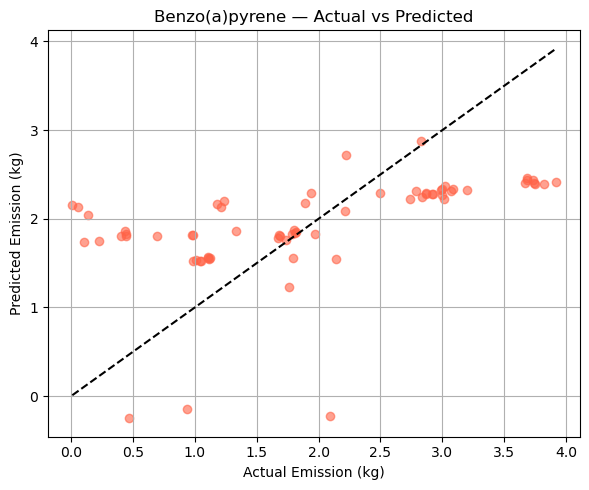

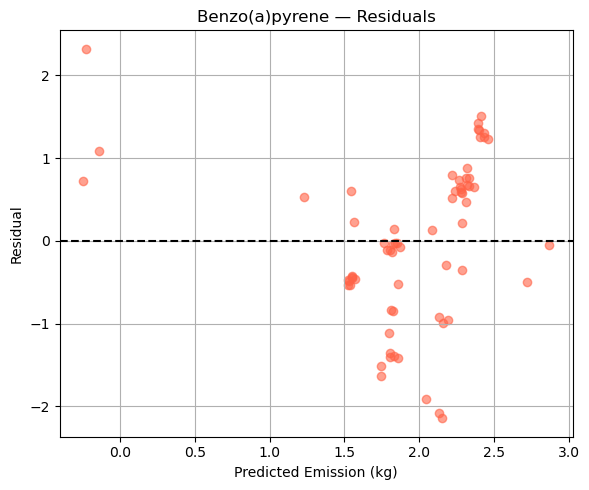

Regression Analyse Results: Copper
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     39.61
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           5.83e-09
Time:                        21:18:24   Log-Likelihood:                -225.55
No. Observations:                 117   AIC:                             455.1
Df Residuals:                     115   BIC:                             460.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        

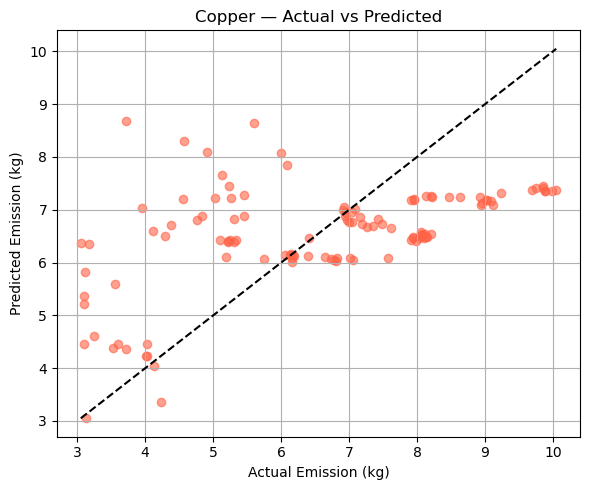

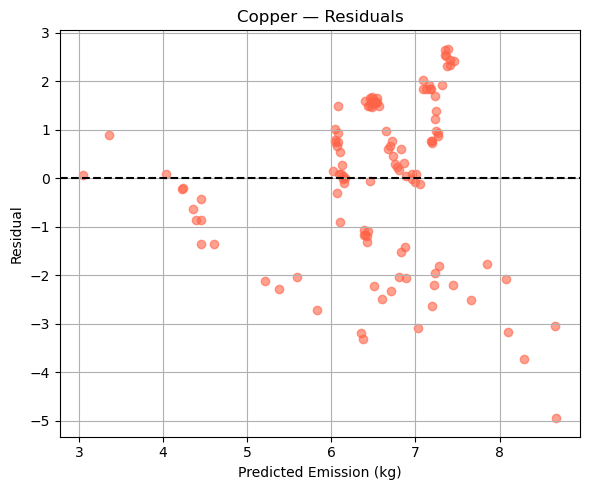

Regression Analyse Results: Fluoranthene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     12.48
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           0.000655
Time:                        21:18:25   Log-Likelihood:                -147.64
No. Observations:                  91   AIC:                             299.3
Df Residuals:                      89   BIC:                             304.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const  

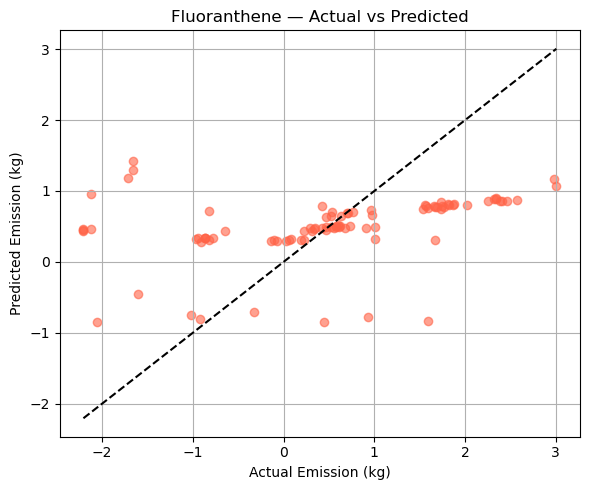

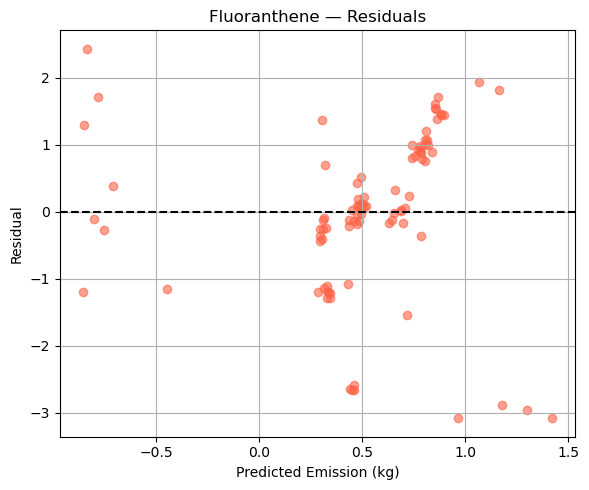

Regression Analyse Results: Indeno(1,2,3-cd)pyrene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     55.40
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           3.09e-10
Time:                        21:18:25   Log-Likelihood:                -73.281
No. Observations:                  66   AIC:                             150.6
Df Residuals:                      64   BIC:                             154.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

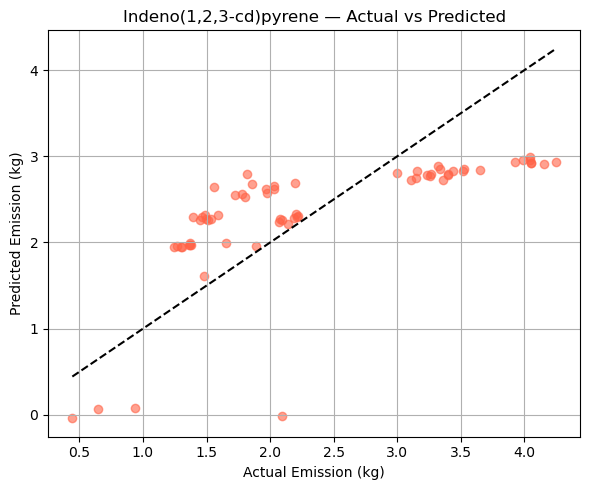

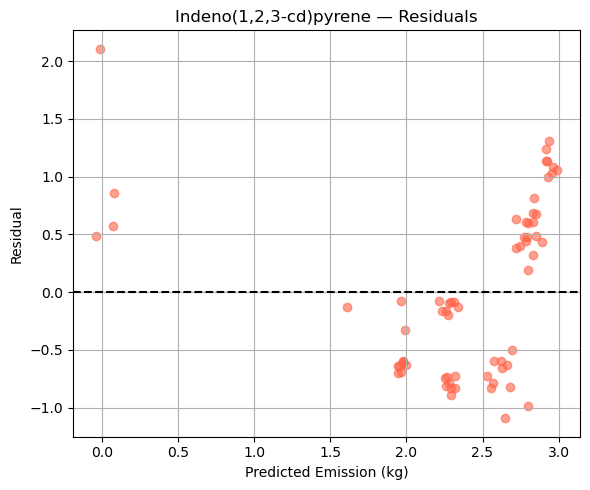

Regression Analyse Results: Cypermethrin
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     14.08
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           0.000413
Time:                        21:18:25   Log-Likelihood:                -131.08
No. Observations:                  59   AIC:                             266.2
Df Residuals:                      57   BIC:                             270.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const  

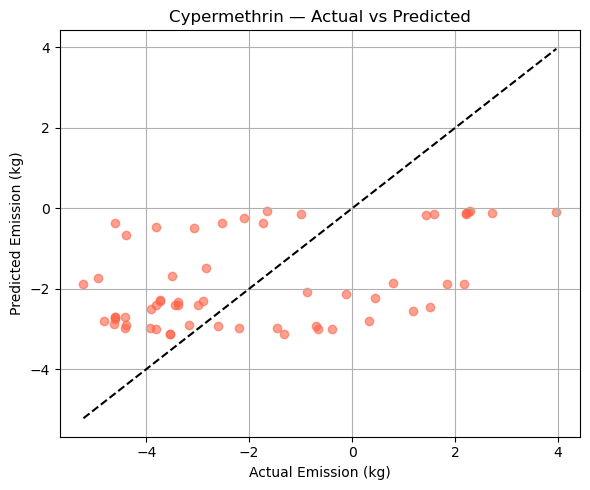

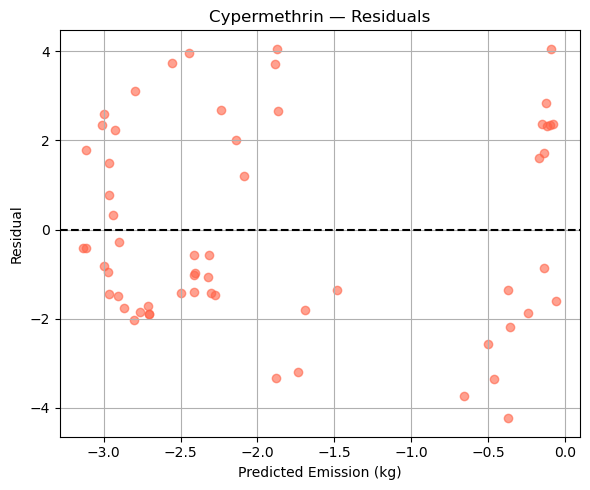

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os


pollutants = merged_df['SUBSTANCE NAME'].dropna().unique()

for pollutant in pollutants:
    print("=" * 100)
    print(f"Regression Analyse Results: {pollutant}")
    print("=" * 100)

    # Filter corresponding pollutants, and the turnover must be greater than 0
    df_sub = merged_df[
        (merged_df['SUBSTANCE NAME'].str.lower() == pollutant.lower()) &
        (merged_df['Turnover_million'] > 0) &
        (merged_df['Employee'] > 0) &
        (merged_df['Total Emission (kg)'] > 0)
    ].copy()

    # If the sample is too small, skip the pollutant
    if df_sub.shape[0] < 10:
        print(f"Too few samples, skip：{pollutant}")
        continue

    df_sub['log_emission'] = np.log(df_sub['Total Emission (kg)'])
    df_sub['log_employee'] = np.log(df_sub['Employee'])
    df_sub['log_turnover'] = np.log(df_sub['Turnover_million'])

    # Remove Inf/nan
    df_sub = df_sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_turnover', 'log_employee', 'log_emission'])

    # Confirm again whether the sample is sufficient
    if df_sub.shape[0] < 10:
        print(f"Insufficient valid samples, skip：{pollutant}")
        continue

    # Set independent and dependent variables
    X = df_sub[['log_turnover']]
    X = sm.add_constant(X)
    y = df_sub['log_emission']

    # fitted model
    model = sm.OLS(y, X).fit()

    # Print regression results
    print(model.summary())

    # Generate predictions and residuals
    y_pred = model.predict(X)
    residuals = y - y_pred

    # Draw picture 1: Actual vs. Prediction
    plt.figure(figsize=(6, 5))
    plt.scatter(y, y_pred, alpha=0.6, color='tomato')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
    plt.xlabel("Actual Emission (kg)")
    plt.ylabel("Predicted Emission (kg)")
    plt.title(f"{pollutant} — Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Draw picture 2: Residual Diagram
    plt.figure(figsize=(6, 5))
    plt.scatter(y_pred, residuals, alpha=0.6, color='tomato')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Predicted Emission (kg)")
    plt.ylabel("Residual")
    plt.title(f"{pollutant} — Residuals")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



**log_emission ~ log_employee**

Regression Analyse Results: Benzo(a)pyrene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     21.73
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           1.58e-05
Time:                        21:20:44   Log-Likelihood:                -94.055
No. Observations:                  68   AIC:                             192.1
Df Residuals:                      66   BIC:                             196.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const

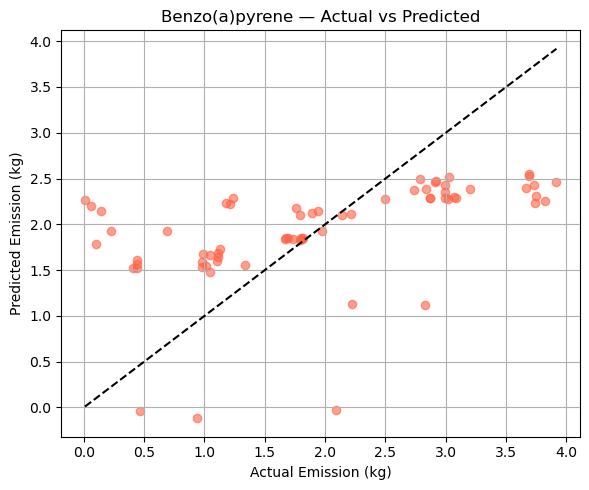

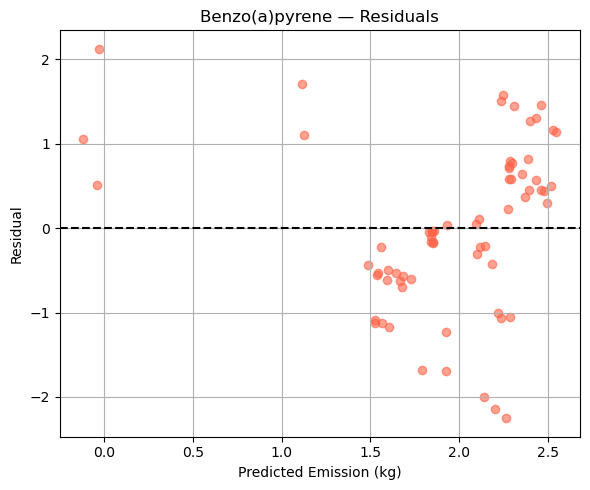

Regression Analyse Results: Copper
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     66.92
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           4.25e-13
Time:                        21:20:45   Log-Likelihood:                -216.03
No. Observations:                 117   AIC:                             436.1
Df Residuals:                     115   BIC:                             441.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        

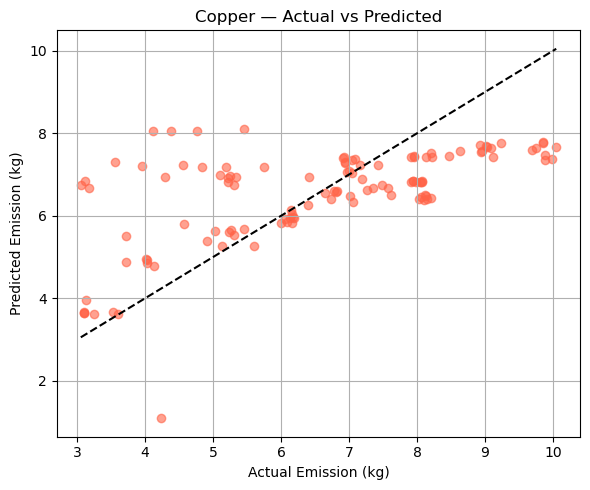

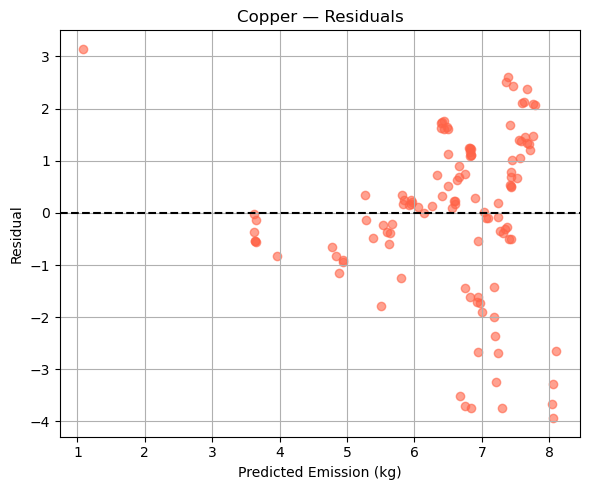

Regression Analyse Results: Fluoranthene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     34.03
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           8.61e-08
Time:                        21:20:45   Log-Likelihood:                -138.87
No. Observations:                  91   AIC:                             281.7
Df Residuals:                      89   BIC:                             286.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const  

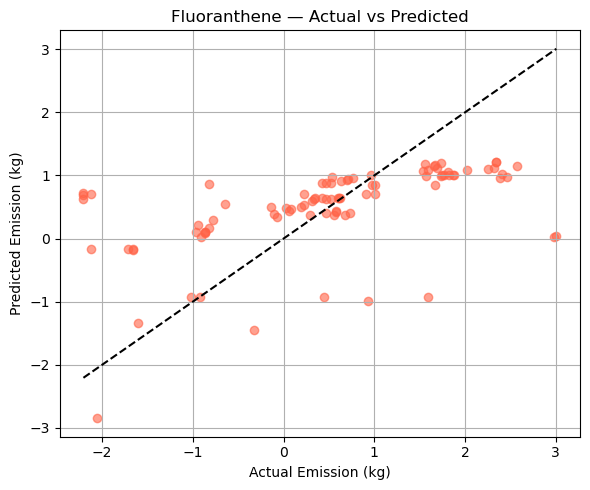

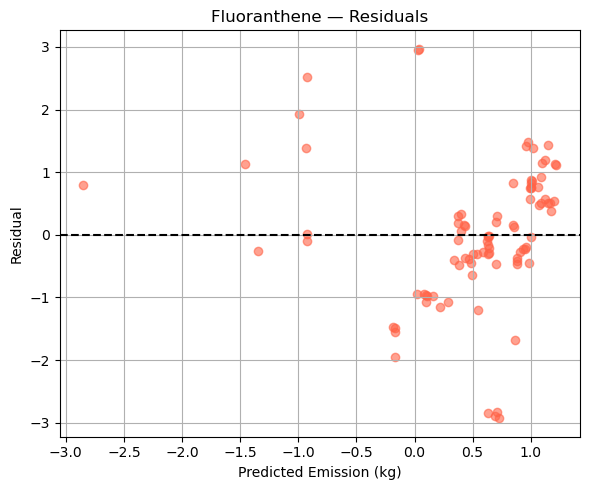

Regression Analyse Results: Indeno(1,2,3-cd)pyrene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     51.99
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           7.94e-10
Time:                        21:20:45   Log-Likelihood:                -74.238
No. Observations:                  66   AIC:                             152.5
Df Residuals:                      64   BIC:                             156.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

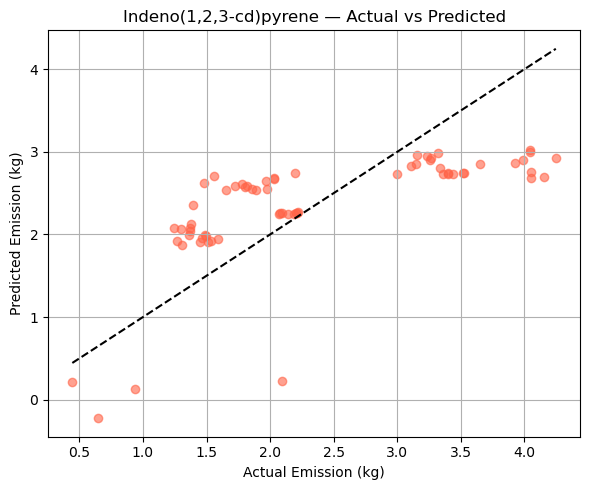

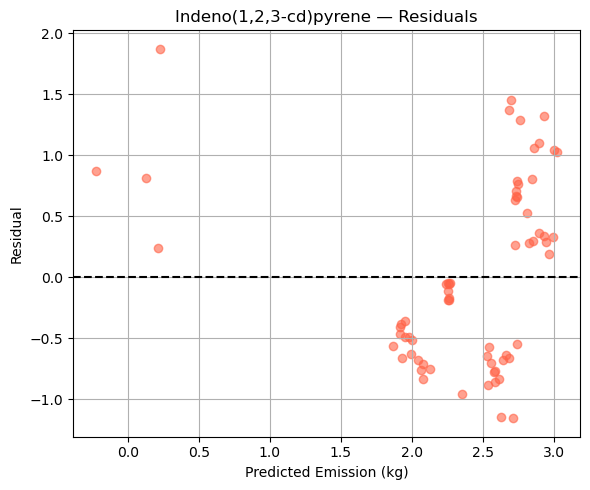

Regression Analyse Results: Cypermethrin
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     3.653
Date:                Thu, 28 Aug 2025   Prob (F-statistic):             0.0610
Time:                        21:20:46   Log-Likelihood:                -135.76
No. Observations:                  59   AIC:                             275.5
Df Residuals:                      57   BIC:                             279.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const  

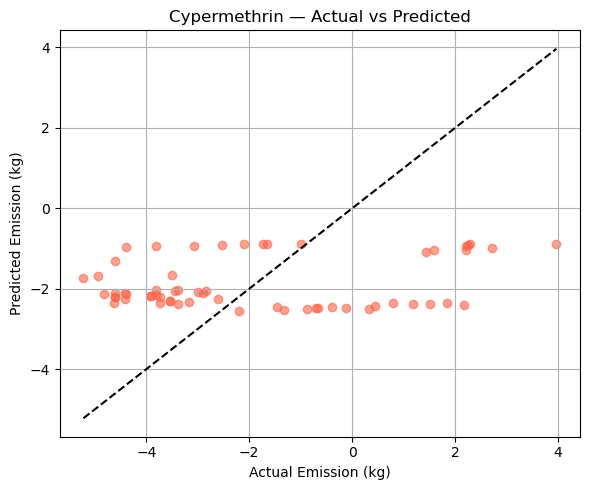

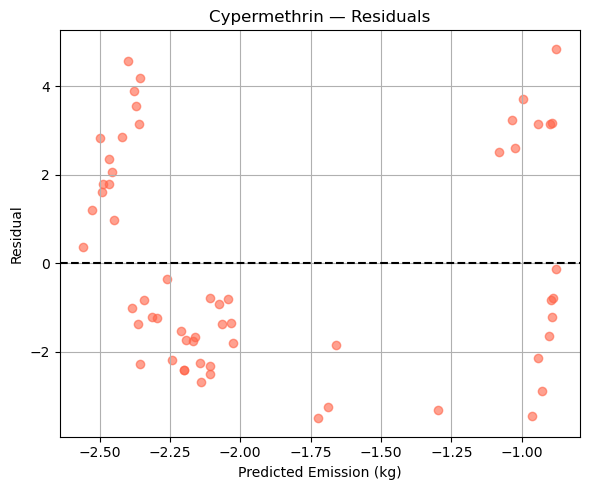

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

pollutants = merged_df['SUBSTANCE NAME'].dropna().unique()

for pollutant in pollutants:
    print("=" * 100)
    print(f"Regression Analyse Results: {pollutant}")
    print("=" * 100)

    df_sub = merged_df[
        (merged_df['SUBSTANCE NAME'].str.lower() == pollutant.lower()) &
        (merged_df['Turnover_million'] > 0) &
        (merged_df['Employee'] > 0) &
        (merged_df['Total Emission (kg)'] > 0)
    ].copy()

    # If the sample is too small, skip the pollutant
    if df_sub.shape[0] < 10:
        print(f"Too few samples, skip：{pollutant}")
        continue

    df_sub['log_emission'] = np.log(df_sub['Total Emission (kg)'])
    df_sub['log_employee'] = np.log(df_sub['Employee'])
    df_sub['log_turnover'] = np.log(df_sub['Turnover_million'])

    df_sub = df_sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_turnover', 'log_employee', 'log_emission'])

    if df_sub.shape[0] < 10:
        print(f"Insufficient valid samples, skip：{pollutant}")
        continue

    X = df_sub[['log_employee']]
    X = sm.add_constant(X)
    y = df_sub['log_emission']

    model = sm.OLS(y, X).fit()

    print(model.summary())

    y_pred = model.predict(X)
    residuals = y - y_pred

    plt.figure(figsize=(6, 5))
    plt.scatter(y, y_pred, alpha=0.6, color='tomato')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
    plt.xlabel("Actual Emission (kg)")
    plt.ylabel("Predicted Emission (kg)")
    plt.title(f"{pollutant} — Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.scatter(y_pred, residuals, alpha=0.6, color='tomato')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Predicted Emission (kg)")
    plt.ylabel("Residual")
    plt.title(f"{pollutant} — Residuals")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



**log_emission ~ Year**

Regression Analyse Results: Benzo(a)pyrene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.4483
Date:                Thu, 28 Aug 2025   Prob (F-statistic):              0.505
Time:                        21:21:56   Log-Likelihood:                -103.50
No. Observations:                  68   AIC:                             211.0
Df Residuals:                      66   BIC:                             215.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

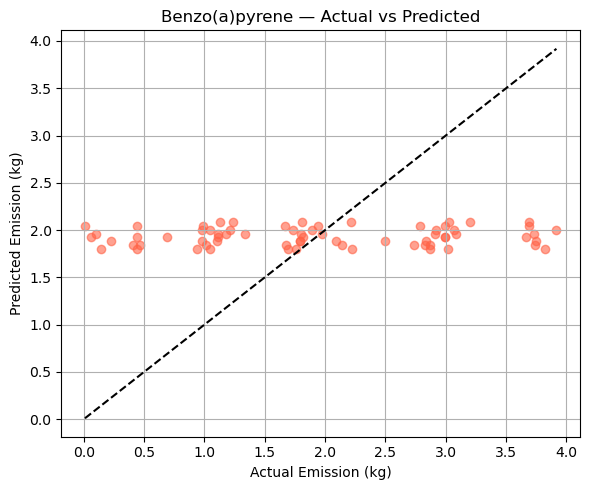

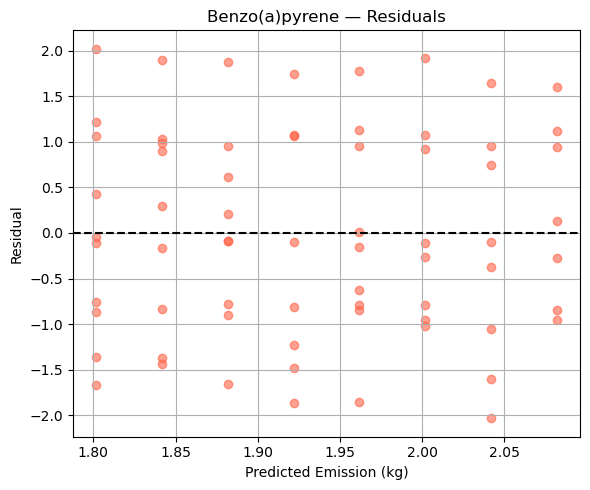

Regression Analyse Results: Copper
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                 0.0008884
Date:                Thu, 28 Aug 2025   Prob (F-statistic):              0.976
Time:                        21:21:57   Log-Likelihood:                -242.87
No. Observations:                 117   AIC:                             489.7
Df Residuals:                     115   BIC:                             495.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.

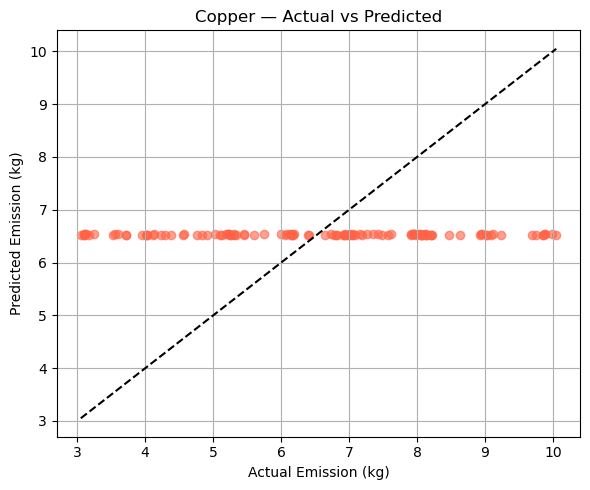

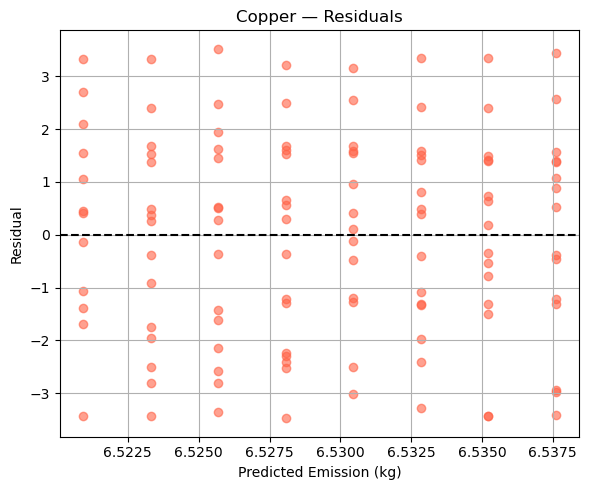

Regression Analyse Results: Fluoranthene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.572
Date:                Thu, 28 Aug 2025   Prob (F-statistic):              0.213
Time:                        21:21:57   Log-Likelihood:                -152.81
No. Observations:                  91   AIC:                             309.6
Df Residuals:                      89   BIC:                             314.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

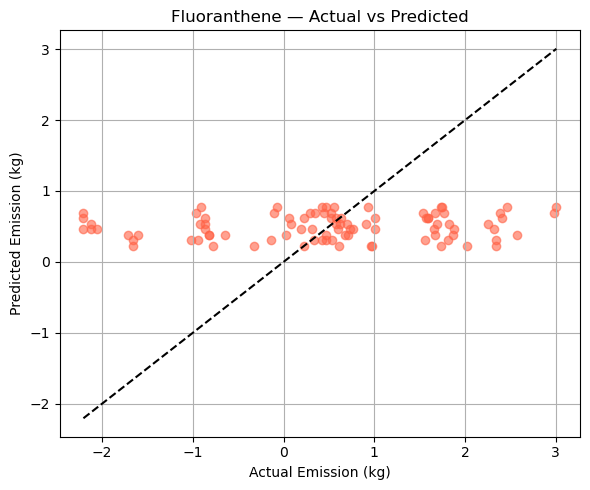

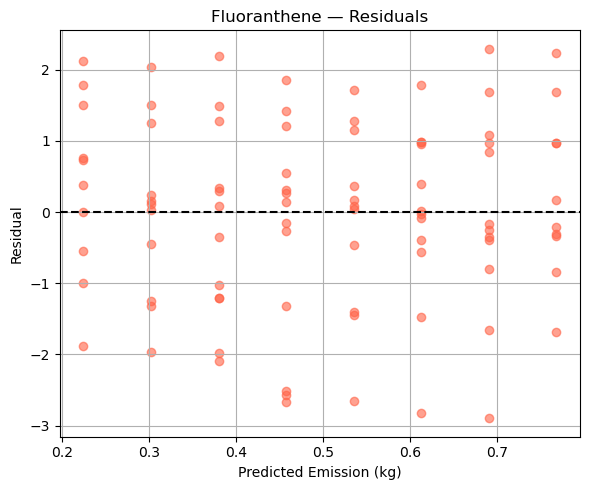

Regression Analyse Results: Indeno(1,2,3-cd)pyrene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.3905
Date:                Thu, 28 Aug 2025   Prob (F-statistic):              0.534
Time:                        21:21:57   Log-Likelihood:                -93.660
No. Observations:                  66   AIC:                             191.3
Df Residuals:                      64   BIC:                             195.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

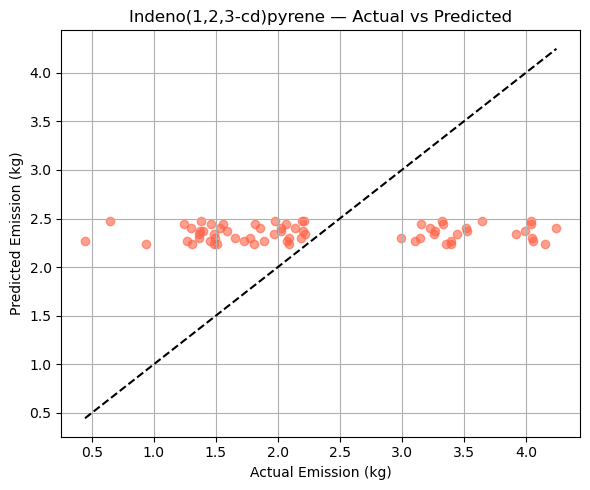

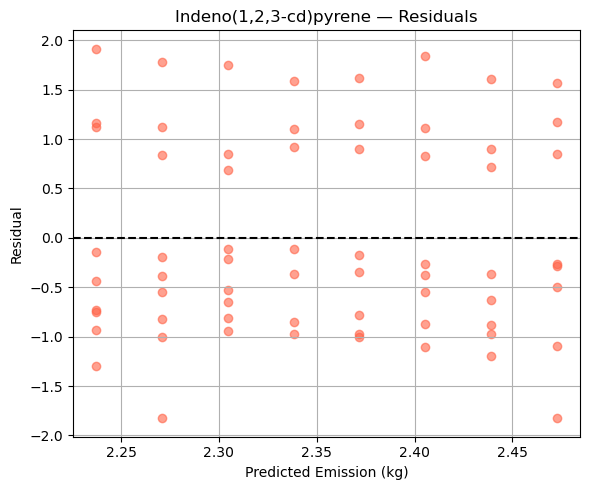

Regression Analyse Results: Cypermethrin
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.4247
Date:                Thu, 28 Aug 2025   Prob (F-statistic):              0.517
Time:                        21:21:58   Log-Likelihood:                -137.37
No. Observations:                  59   AIC:                             278.7
Df Residuals:                      57   BIC:                             282.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

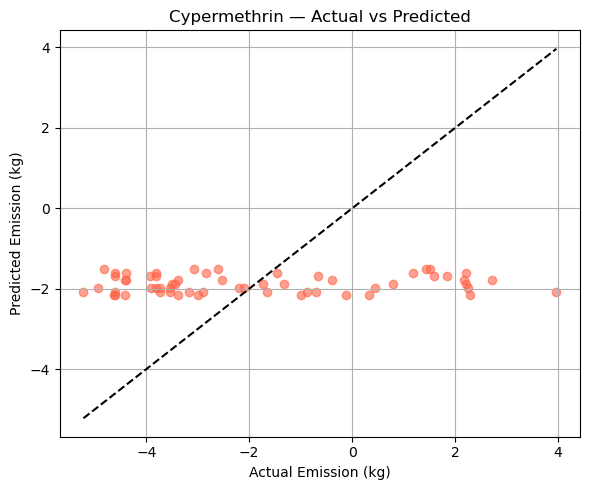

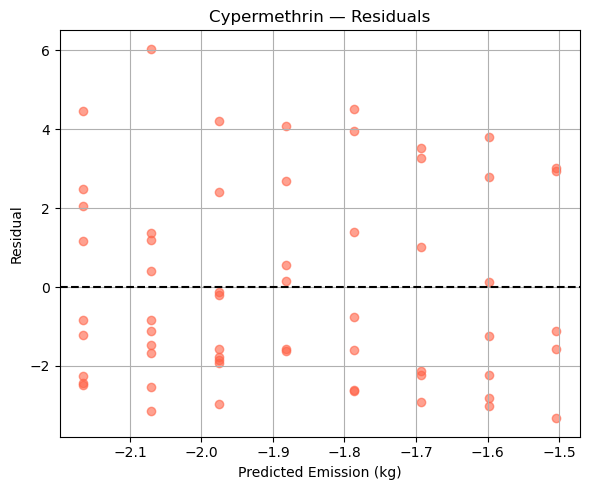

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

pollutants = merged_df['SUBSTANCE NAME'].dropna().unique()

for pollutant in pollutants:
    print("=" * 100)
    print(f"Regression Analyse Results: {pollutant}")
    print("=" * 100)

    df_sub = merged_df[
        (merged_df['SUBSTANCE NAME'].str.lower() == pollutant.lower()) &
        (merged_df['Turnover_million'] > 0) &
        (merged_df['Employee'] > 0) &
        (merged_df['Total Emission (kg)'] > 0)
    ].copy()

    if df_sub.shape[0] < 10:
        print(f"Too few samples, skip：{pollutant}")
        continue

    df_sub['log_emission'] = np.log(df_sub['Total Emission (kg)'])
    df_sub['log_employee'] = np.log(df_sub['Employee'])
    df_sub['log_turnover'] = np.log(df_sub['Turnover_million'])

    df_sub = df_sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_turnover', 'log_employee', 'log_emission'])

    if df_sub.shape[0] < 10:
        print(f"Insufficient valid samples, skip：{pollutant}")
        continue

    X = df_sub[['Year']]
    X = sm.add_constant(X)
    y = df_sub['log_emission']

    model = sm.OLS(y, X).fit()

    print(model.summary())

    y_pred = model.predict(X)
    residuals = y - y_pred

    plt.figure(figsize=(6, 5))
    plt.scatter(y, y_pred, alpha=0.6, color='tomato')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
    plt.xlabel("Actual Emission (kg)")
    plt.ylabel("Predicted Emission (kg)")
    plt.title(f"{pollutant} — Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.scatter(y_pred, residuals, alpha=0.6, color='tomato')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Predicted Emission (kg)")
    plt.ylabel("Residual")
    plt.title(f"{pollutant} — Residuals")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



**log_emission ~ log_turnover + log_employee**

Regression Analyse Results: Benzo(a)pyrene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     12.77
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           2.10e-05
Time:                        21:24:09   Log-Likelihood:                -92.461
No. Observations:                  68   AIC:                             190.9
Df Residuals:                      65   BIC:                             197.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const

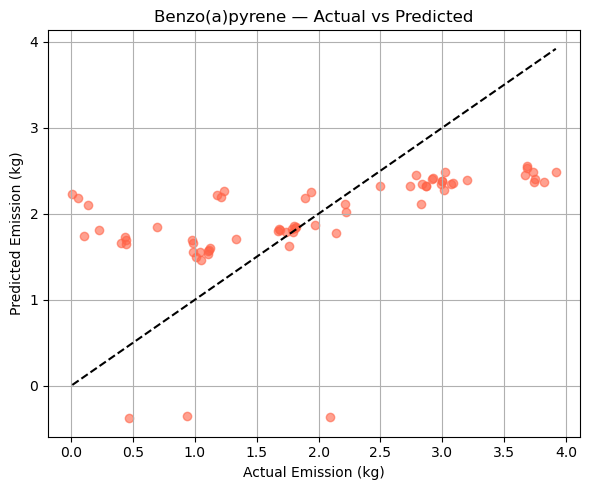

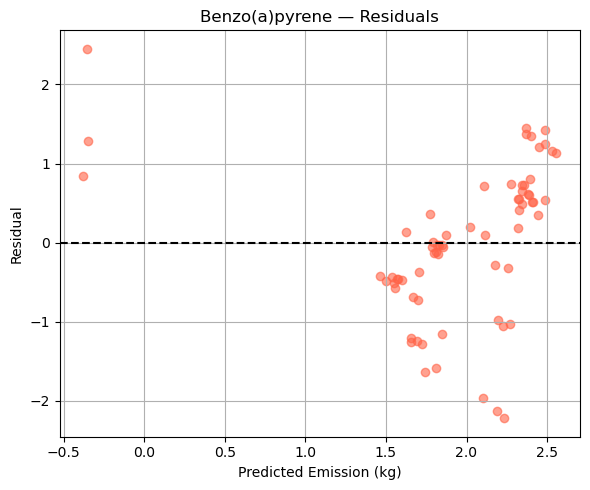

Regression Analyse Results: Copper
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     36.74
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           4.85e-13
Time:                        21:24:09   Log-Likelihood:                -213.77
No. Observations:                 117   AIC:                             433.5
Df Residuals:                     114   BIC:                             441.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        

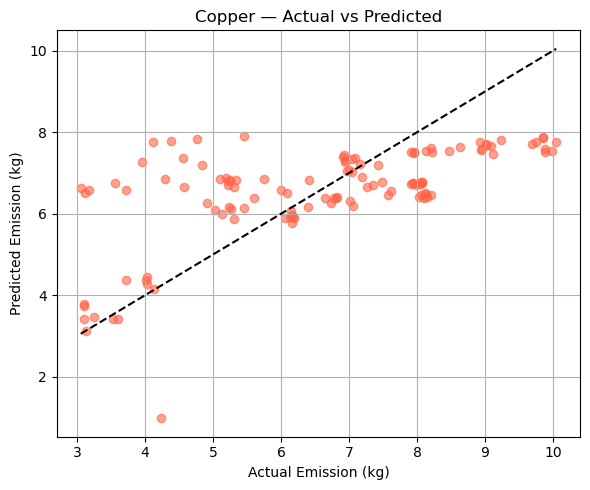

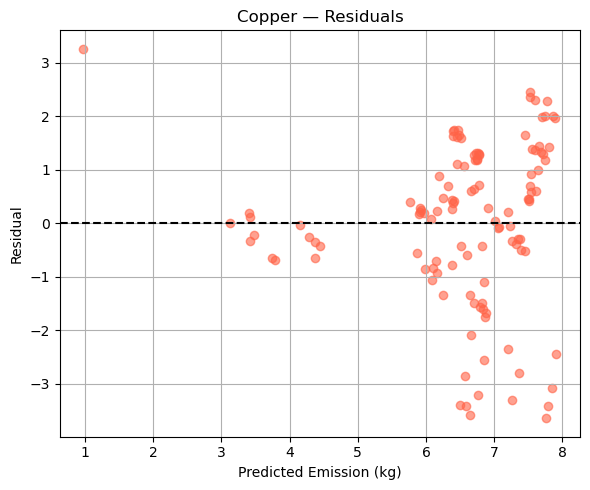

Regression Analyse Results: Fluoranthene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     17.09
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           5.35e-07
Time:                        21:24:10   Log-Likelihood:                -138.68
No. Observations:                  91   AIC:                             283.4
Df Residuals:                      88   BIC:                             290.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const  

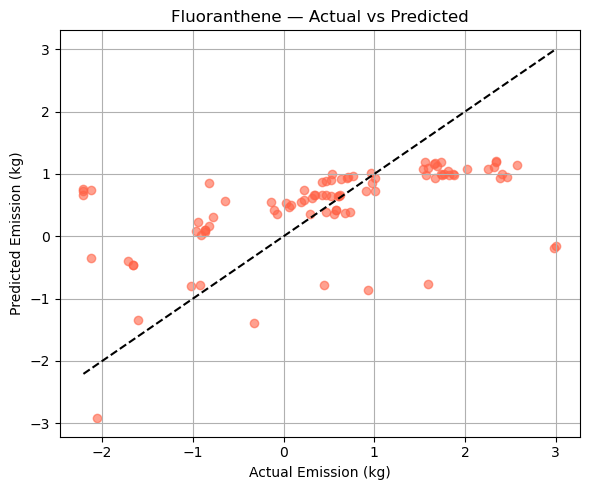

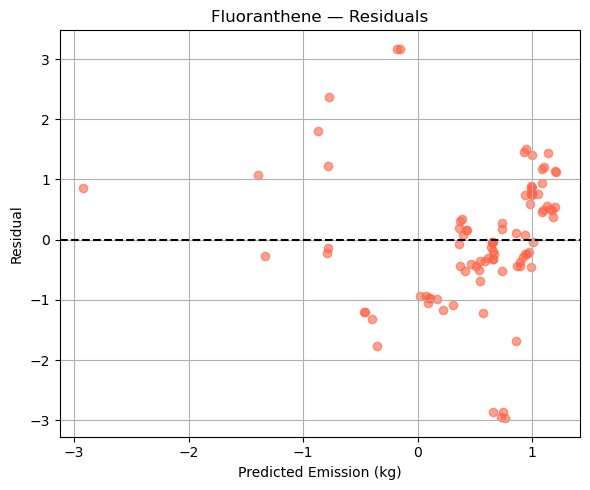

Regression Analyse Results: Indeno(1,2,3-cd)pyrene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     27.87
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           2.14e-09
Time:                        21:24:10   Log-Likelihood:                -72.945
No. Observations:                  66   AIC:                             151.9
Df Residuals:                      63   BIC:                             158.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

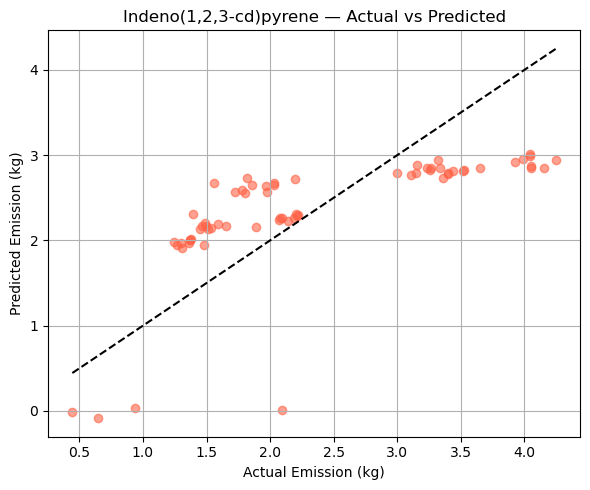

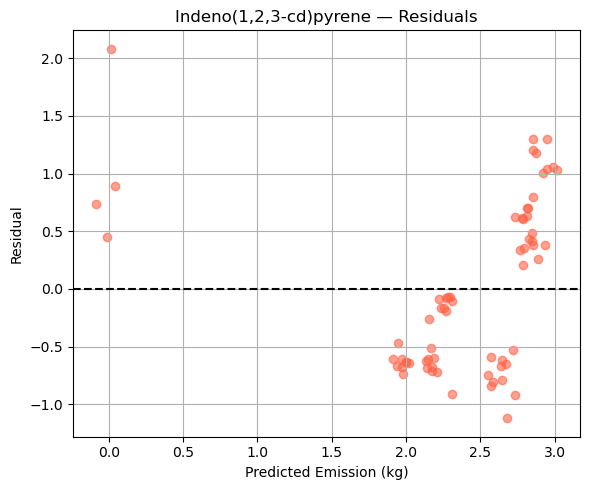

Regression Analyse Results: Cypermethrin
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     21.46
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           1.21e-07
Time:                        21:24:10   Log-Likelihood:                -120.81
No. Observations:                  59   AIC:                             247.6
Df Residuals:                      56   BIC:                             253.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const  

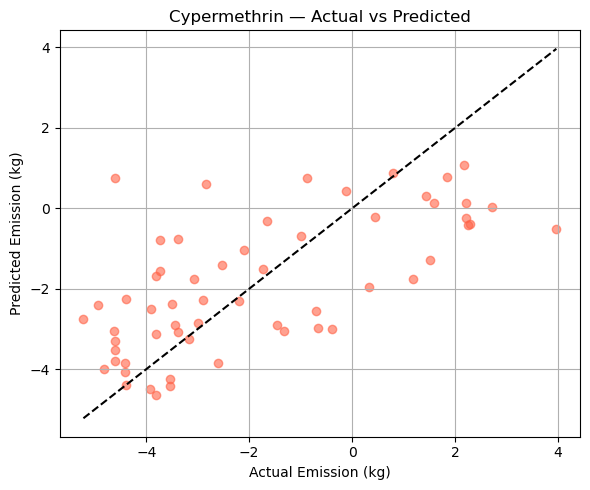

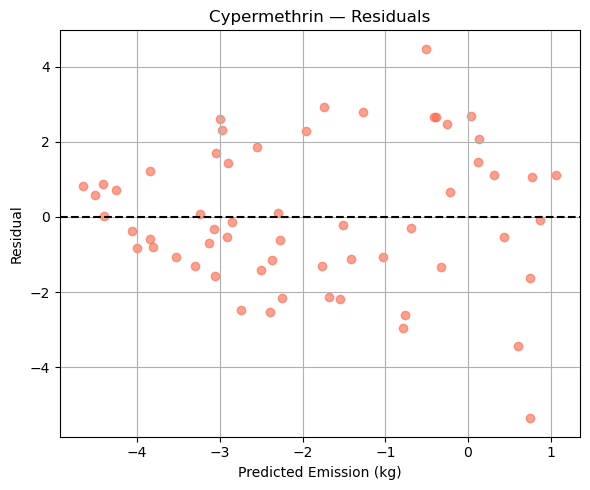

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

pollutants = merged_df['SUBSTANCE NAME'].dropna().unique()

for pollutant in pollutants:
    print("=" * 100)
    print(f"Regression Analyse Results: {pollutant}")
    print("=" * 100)

    df_sub = merged_df[
        (merged_df['SUBSTANCE NAME'].str.lower() == pollutant.lower()) &
        (merged_df['Turnover_million'] > 0) &
        (merged_df['Employee'] > 0) &
        (merged_df['Total Emission (kg)'] > 0)
    ].copy()

    if df_sub.shape[0] < 10:
        print(f"Too few samples, skip：{pollutant}")
        continue

    df_sub['log_emission'] = np.log(df_sub['Total Emission (kg)'])
    df_sub['log_employee'] = np.log(df_sub['Employee'])
    df_sub['log_turnover'] = np.log(df_sub['Turnover_million'])

    df_sub = df_sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_turnover', 'log_employee', 'log_emission'])

    if df_sub.shape[0] < 10:
        print(f"Insufficient valid samples, skip：{pollutant}")
        continue

    X = df_sub[['log_turnover', 'log_employee']]
    X = sm.add_constant(X)
    y = df_sub['log_emission']

    model = sm.OLS(y, X).fit()

    print(model.summary())

    y_pred = model.predict(X)
    residuals = y - y_pred

    plt.figure(figsize=(6, 5))
    plt.scatter(y, y_pred, alpha=0.6, color='tomato')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
    plt.xlabel("Actual Emission (kg)")
    plt.ylabel("Predicted Emission (kg)")
    plt.title(f"{pollutant} — Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.scatter(y_pred, residuals, alpha=0.6, color='tomato')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Predicted Emission (kg)")
    plt.ylabel("Residual")
    plt.title(f"{pollutant} — Residuals")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)


        feature        VIF
0         const  27.208555
1  log_turnover   8.055188
2  log_employee   8.055188


**Panel OLS**

In [24]:
import numpy as np
import pandas as pd

# Unified company name column
if 'Company_Clean' in merged_df.columns:
    merged_df['OPERATOR NAME'] = (
        merged_df['Company_Clean'].astype(str).str.strip().str.lower()
    )
elif 'OPERATOR NAME' in merged_df.columns:
    merged_df['OPERATOR NAME'] = merged_df['OPERATOR NAME'].astype(str).str.strip().str.lower()
else:
    raise ValueError("既没有 Company_Clean 也没有 OPERATOR NAME，无法识别公司列。")

# Turnover_million
if 'Turnover_million' not in merged_df.columns and 'Turnover' in merged_df.columns:
    merged_df['Turnover_million'] = merged_df['Turnover'] / 1e6

# logarithm
merged_df = merged_df[
    (merged_df['Total Emission (kg)'] > 0) &
    (merged_df['Employee'] > 0) &
    (merged_df['Turnover_million'] > 0)
].copy()

# Log variable
merged_df['log_emission']  = np.log(merged_df['Total Emission (kg)'])
merged_df['log_employee']  = np.log(merged_df['Employee'])
merged_df['log_turnover']  = np.log(merged_df['Turnover_million'])

# lowercase
merged_df['SUBSTANCE NAME'] = merged_df['SUBSTANCE NAME'].astype(str).str.strip().str.lower()

# check
need = ['OPERATOR NAME','Year','log_emission','log_turnover','log_employee','SUBSTANCE NAME']
print("missing：", [c for c in need if c not in merged_df.columns])


missing： []


In [28]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS

# cleaning 
df = merged_df.copy()
df.columns = df.columns.str.strip()

if 'Company_Clean' in df.columns:
    df['OPERATOR NAME'] = df['Company_Clean'].astype(str).str.strip().str.lower()
else:
    df['OPERATOR NAME'] = df['OPERATOR NAME'].astype(str).str.strip().str.lower()

# Turnover_million
if 'Turnover_million' not in df.columns and 'Turnover' in df.columns:
    df['Turnover_million'] = df['Turnover'] / 1e6

df = df[
    (df['Total Emission (kg)'] > 0) &
    (df['Employee'] > 0) &
    (df['Turnover_million'] > 0)
].copy()

df['log_emission']  = np.log(df['Total Emission (kg)'])
df['log_employee']  = np.log(df['Employee'])
df['log_turnover']  = np.log(df['Turnover_million'])

df['SUBSTANCE NAME'] = df['SUBSTANCE NAME'].astype(str).str.strip().str.lower()

target_pollutants = df['SUBSTANCE NAME'].dropna().unique().tolist()

results_rows = []

def _safe_total(series_like):
    try:
        return int(series_like.loc['total'])
    except Exception:
        return np.nan

for pol in target_pollutants:
    sub = df[df['SUBSTANCE NAME'] == pol].copy()

    # At least 2 companies x 2 years, with a sample size of ≥ 20
    if sub['OPERATOR NAME'].nunique() < 2 or sub['Year'].nunique() < 2 or len(sub) < 20:
        print(f"【jump】{pol}：Insufficient effective panel samples（firm={sub['OPERATOR NAME'].nunique()}，年={sub['Year'].nunique()}，n={len(sub)}）")
        continue

    # Company x year
    panel_df = sub.set_index(['OPERATOR NAME', 'Year']).sort_index()

    # Company + year
    model = PanelOLS.from_formula(
        'log_emission ~ log_turnover + log_employee + EntityEffects + TimeEffects',
        data=panel_df
    )
    res = model.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

    print("\n" + "="*90)
    print(f"Fixed-Effects OLS (Two-way) — {pol}")
    print("="*90)
    print(res.summary)

    # key indicators
    params  = res.params
    pvals   = res.pvalues
    tstats  = res.tstats
    rsq_w   = getattr(res.rsquared, 'within',  np.nan)
    rsq_b   = getattr(res.rsquared, 'between', np.nan)
    rsq_o   = getattr(res.rsquared, 'overall', np.nan)
    n_firms = _safe_total(getattr(res, 'entity_info', pd.Series(dtype=float)))
    n_years = _safe_total(getattr(res, 'time_info',   pd.Series(dtype=float)))

    results_rows.append({
        'pollutant'            : pol,
        'n_obs'                : int(res.nobs),
        'n_firms'              : n_firms,
        'n_years'              : n_years,
        'R2_within'            : rsq_w,
        'R2_between'           : rsq_b,
        'R2_overall'           : rsq_o,
        'coef_log_turnover'    : params.get('log_turnover',  np.nan),
        't_log_turnover'       : tstats.get('log_turnover',  np.nan),
        'p_log_turnover'       : pvals.get('log_turnover',   np.nan),
        'coef_log_employee'    : params.get('log_employee',  np.nan),
        't_log_employee'       : tstats.get('log_employee',  np.nan),
        'p_log_employee'       : pvals.get('log_employee',   np.nan),
    })

# Summary table
fe_summary = pd.DataFrame(results_rows)
if fe_summary.empty:
    print("No panel results that can be summarized")
else:
    fe_summary = fe_summary.sort_values('pollutant')
    display(fe_summary)




Fixed-Effects OLS (Two-way) — benzo(a)pyrene
                          PanelOLS Estimation Summary                           
Dep. Variable:           log_emission   R-squared:                        0.0332
Estimator:                   PanelOLS   R-squared (Between):              0.7278
No. Observations:                  68   R-squared (Within):               0.0229
Date:                Thu, Aug 28 2025   R-squared (Overall):              0.7031
Time:                        21:31:22   Log-likelihood                    0.1011
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.8066
Entities:                          12   P-value                           0.4525
Avg Obs:                       5.6667   Distribution:                    F(2,47)
Min Obs:                       2.0000                                           
Max Obs:                       8.0000   F-statistic (robust):  

,pollutant,n_obs,n_firms,n_years,R2_within,R2_between,R2_overall,coef_log_turnover,t_log_turnover,p_log_turnover,coef_log_employee,t_log_employee,p_log_employee
0,benzo(a)pyrene,68,12,8,NaN,NaN,NaN,0.510194,1.561821,0.125039,-0.276836,-0.506246,0.615051
1,copper,117,22,8,NaN,NaN,NaN,0.177235,0.722647,0.471857,0.285055,0.304553,0.761442
4,cypermethrin,59,15,8,NaN,NaN,NaN,0.307049,0.650946,0.519333,1.446253,1.600344,0.118511
2,fluoranthene,91,18,8,NaN,NaN,NaN,-0.050837,-0.100360,0.920372,0.435346,0.415874,0.678893
3,"indeno(1,2,3-cd)pyrene",66,11,8,NaN,NaN,NaN,0.615471,2.782103,0.007806,-0.159357,-0.940046,0.352104
